In [1]:
!pip install logicalinduction

In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import logicalinduction as li

In [3]:
sentence1 = li.Atom("socrates is a man")
sentence2 = li.Atom("socrates is mortal")
sentence3 = li.Implication(sentence1, sentence2)

In [4]:
def trade_on_probability(sentence, day, p, slope=10):
    return li.Min(
        li.Constant(1),
        li.Max(
            li.Constant(-1),
            li.Sum(
                li.Constant(slope * p),
                li.Product(
                    li.Constant(-slope),
                    li.Price(sentence1, day)
                )
            )
        )
    )

In [5]:
def trading_alg(sentence, probability):
    for i in li.integers(start=1):
        yield {sentence: trade_on_probability(sentence, i, probability)}

In [6]:
belief_history = li.History([{sentence1: .1}])

In [7]:
belief_history.lookup(sentence1, 1)

0.1

In [8]:
first_trading_policy = next(trading_alg(sentence1, .8))

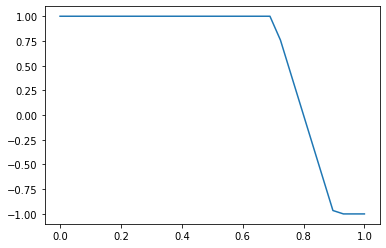

In [9]:
credences = np.linspace(0, 1, 30)
purchase_quantities = [first_trading_policy[sentence1].evaluate(li.History([{sentence1: cr}])) for cr in credences]
plt.plot(credences, purchase_quantities)

In [14]:
history = li.History()   # empty history
credences = li.find_credences(first_trading_policy, history, tolerance=.01)
credences

{socrates is a man: Fraction(4, 5)}

In [36]:
def value_of_holdings_landscape(trading_policy, credence_history, x_sentence, y_sentence):
    min_possible = np.zeros((20, 20))
    max_possible = np.zeros((20, 20))
    for i, x in enumerate(np.linspace(0, 1, 20)):
        for j, y in enumerate(np.linspace(0, 1, 20)):
            credences = {x_sentence: x, y_sentence: y}
            history = credence_history.with_next_update(credences)

            # check all possible worlds (all possible truth values for the support sentences)
            possible_values = []
            for truth_values in itertools.product([0, 1], repeat=2):
                world = {sentence1: truth_values[0], sentence2: truth_values[1]}
                value_of_holdings = li.evaluate(trading_policy, history, world)
                possible_values.append(value_of_holdings)
                
            min_possible[j,i] = min(possible_values)
            max_possible[j,i] = max(possible_values)

    return min_possible, max_possible

min_landscape, max_landscape = value_of_holdings_landscape(first_trading_policy, history, sentence1, sentence2)

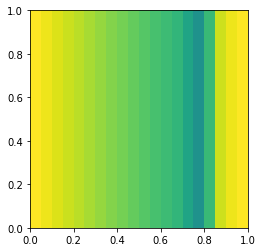

In [35]:
plt.imshow(max_landscape, extent=(0, 1, 0, 1), vmin=-1, vmax=1)

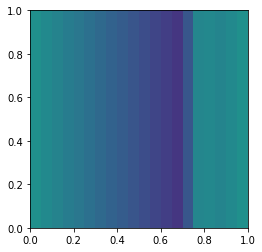

In [37]:
plt.imshow(min_landscape, extent=(0, 1, 0, 1), vmin=-1, vmax=1)

In [40]:
second_trading_policy = {
    sentence1: trade_on_probability(sentence1, 1, .1),
    sentence2: trade_on_probability(sentence2, 1, .3)
}

In [41]:
min_landscape, max_landscape = value_of_holdings_landscape(second_trading_policy, history, sentence1, sentence2)

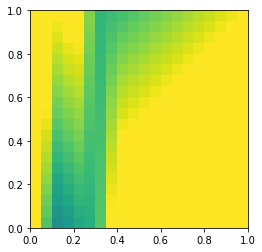

In [42]:
plt.imshow(max_landscape, extent=(0, 1, 0, 1), vmin=-1, vmax=1)

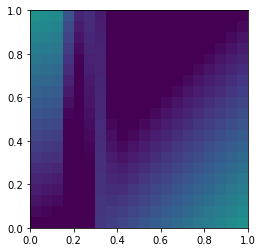

In [43]:
plt.imshow(min_landscape, extent=(0, 1, 0, 1), vmin=-1, vmax=1)

In [47]:
budget_factor = li.compute_budget_factor(
    budget=2,
    observation_history=[],
    next_observation=sentence1,
    trading_history=[],
    next_trading_formulas=second_trading_policy,
    credence_history=history)

print(budget_factor.tree())

SafeReciprocal
. Max
. . Product
. . . Constant(0.5)
. . . Product
. . . . Constant(-1)
. . . . Sum
. . . . . Product
. . . . . . Min
. . . . . . . Constant(1)
. . . . . . . Max
. . . . . . . . Constant(-1)
. . . . . . . . Sum
. . . . . . . . . Constant(1.0)
. . . . . . . . . Product
. . . . . . . . . . Constant(-10)
. . . . . . . . . . Price(socrates is a man, 1)
. . . . . . Sum
. . . . . . . Constant(1.0)
. . . . . . . Product
. . . . . . . . Constant(-1)
. . . . . . . . Price(socrates is a man, 1)
. . . . . Product
. . . . . . Min
. . . . . . . Constant(1)
. . . . . . . Max
. . . . . . . . Constant(-1)
. . . . . . . . Sum
. . . . . . . . . Constant(3.0)
. . . . . . . . . Product
. . . . . . . . . . Constant(-10)
. . . . . . . . . . Price(socrates is a man, 1)
. . . . . . Sum
. . . . . . . Constant(1.0)
. . . . . . . Product
. . . . . . . . Constant(-1)
. . . . . . . . Price(socrates is mortal, 1)
. . Product
. . . Constant(0.5)
. . . Product
. . . . Constant(-1)
. . . . Sum
. . . . 

In [51]:
print(second_trading_policy[sentence1].tree())

Min
. Constant(1)
. Max
. . Constant(-1)
. . Sum
. . . Constant(1.0)
. . . Product
. . . . Constant(-10)
. . . . Price(socrates is a man, 1)
